# Introduction - Mission Meteor

In the world of space exploration, the stakes are high and every detail matters. Weather is the one of the most unpredictable variables in a lunch mission. Mission Meteor is our answer to this challenge. Our goal is to develop different classification models able to accurately classify weather conditions using weather related data, which is a critical component for determining lunch viability in real time. 

We are working with a dataset that contains multiple atmospheric features, including temperature, humidity, wind speed, and pressure. Each row represents a unique weather condition, along with a target label indicating the overall weather classification. We will train the models to learn from these features and predict the correct weather category with high accuracy.

To accomplish this, we will experiment with three classification models, which are Decision Trees, Random Forests, and XGBoost. These models will be evaluated and compared using different metrics to determine the most effective approach for weather classification, the type where one day could decide whether a rocket launches on time or waits for clearer skies.

### About the Data 



In [4]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

This dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/nikhil7280/weather-type-classification). It's a
synthetic dataset which was created for students and data scientists to practice data preprocessing, feature engineering, model evaluation, and other data mining tasks. The dataset has 11 features and 13,200 samples. 

In [7]:
df = pd.read_csv("weather_classification_data.csv")

In [9]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [11]:
df.describe()

# Humidity ranges from 20% to 109%, this is a due to the dataset being synthetic and the creator
# of the dataset not accounting for real world values. The same issue occurs with precipitation.
# Visibility has a minimum of 0, which also doesn't occur in real world conditions. UV index in the
# dataset ranges from 0 to 14. Real world UV range is from 1 to 11+ (with 12,13,14 being extremely unlikely).

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


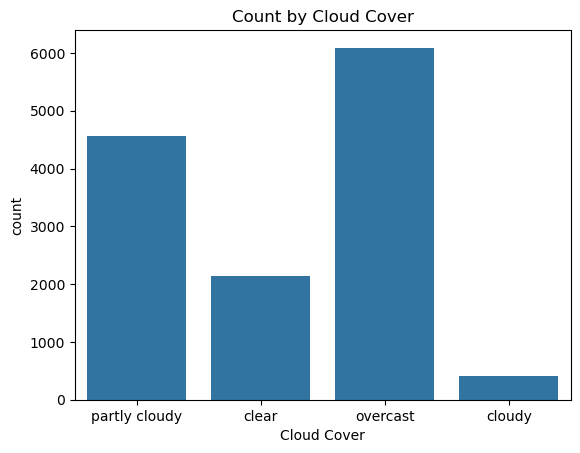

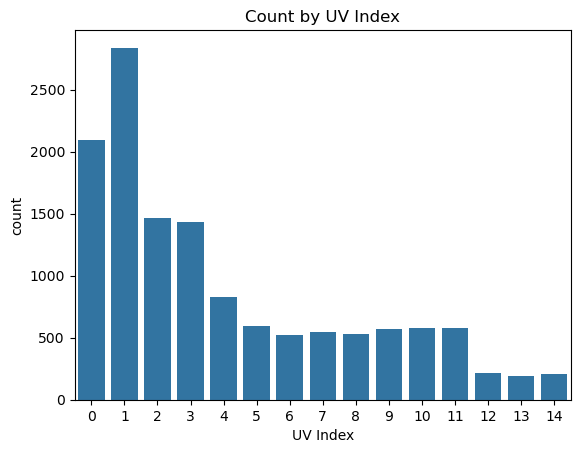

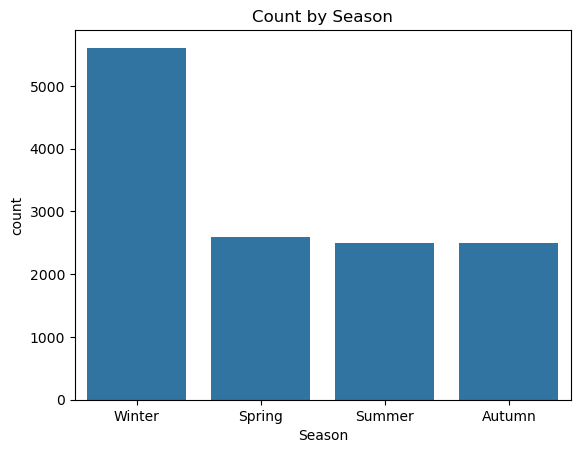

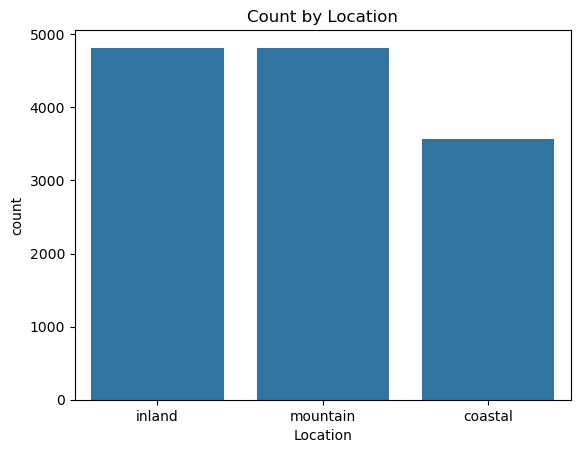

In [13]:
# plot distribution of discrete features

# Overcast conditions occurred most frequently, followed by partly cloudy, clear, and then cloudy skies.
# UV Index values are most commonly low, with frequency decreasing as the index increases.
# Winter had the highest observation count, while the other seasons had roughly equal and lower counts.
# Inland and mountain regions had similar and higher observation counts compared to coastal areas.
# All four weather types (Rainy, Cloudy, Sunny, and Snowy—had equal counts) showing a balanced distribution.

categorical_features = ['Cloud Cover', 'UV Index', 'Season', 'Location']

for cat in categorical_features:
    sns.countplot(data=df, x=cat)
    plt.title(f'Count by {cat}')
    plt.show()

# Pre-Processing

In [16]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df[categorical_features])
encoded = encoder.transform(df[categorical_features])
column_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded, columns=column_names, index=df.index)
non_categorical = df.drop(columns=categorical_features)

# merge
processed_df = pd.concat([non_categorical, encoded_df], axis=1)

### Correcting issues with synthetic data
![Weatherman!](weatherman.png)

In [19]:
# remove precipitations over 100%

processed_df = processed_df[processed_df["Precipitation (%)"] <= 100]
processed_df["Precipitation (%)"].describe()

count    12808.000000
mean        52.072923
std         31.119669
min          0.000000
25%         19.000000
50%         56.000000
75%         80.000000
max        100.000000
Name: Precipitation (%), dtype: float64

In [21]:
processed_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,Visibility (km),Weather Type,Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,...,UV Index_12,UV Index_13,UV Index_14,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14.0,73,9.5,82.0,1010.82,3.5,Rainy,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,39.0,96,8.5,71.0,1011.43,10.0,Cloudy,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,30.0,64,7.0,16.0,1018.72,5.5,Sunny,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,38.0,83,1.5,82.0,1026.25,1.0,Sunny,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,27.0,74,17.0,66.0,990.67,2.5,Rainy,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [23]:
# count nulls
# data is synthetic so should be 0
processed_df.isnull().sum()

Temperature                  0
Humidity                     0
Wind Speed                   0
Precipitation (%)            0
Atmospheric Pressure         0
Visibility (km)              0
Weather Type                 0
Cloud Cover_clear            0
Cloud Cover_cloudy           0
Cloud Cover_overcast         0
Cloud Cover_partly cloudy    0
UV Index_0                   0
UV Index_1                   0
UV Index_2                   0
UV Index_3                   0
UV Index_4                   0
UV Index_5                   0
UV Index_6                   0
UV Index_7                   0
UV Index_8                   0
UV Index_9                   0
UV Index_10                  0
UV Index_11                  0
UV Index_12                  0
UV Index_13                  0
UV Index_14                  0
Season_Autumn                0
Season_Spring                0
Season_Summer                0
Season_Winter                0
Location_coastal             0
Location_inland              0
Location

In [25]:
# Removing temperature outliers
processed_df = processed_df[processed_df['Temperature'] < 56]

processed_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,Visibility (km),Weather Type,Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,...,UV Index_12,UV Index_13,UV Index_14,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14.0,73,9.5,82.0,1010.82,3.5,Rainy,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,39.0,96,8.5,71.0,1011.43,10.0,Cloudy,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,30.0,64,7.0,16.0,1018.72,5.5,Sunny,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,38.0,83,1.5,82.0,1026.25,1.0,Sunny,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,27.0,74,17.0,66.0,990.67,2.5,Rainy,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


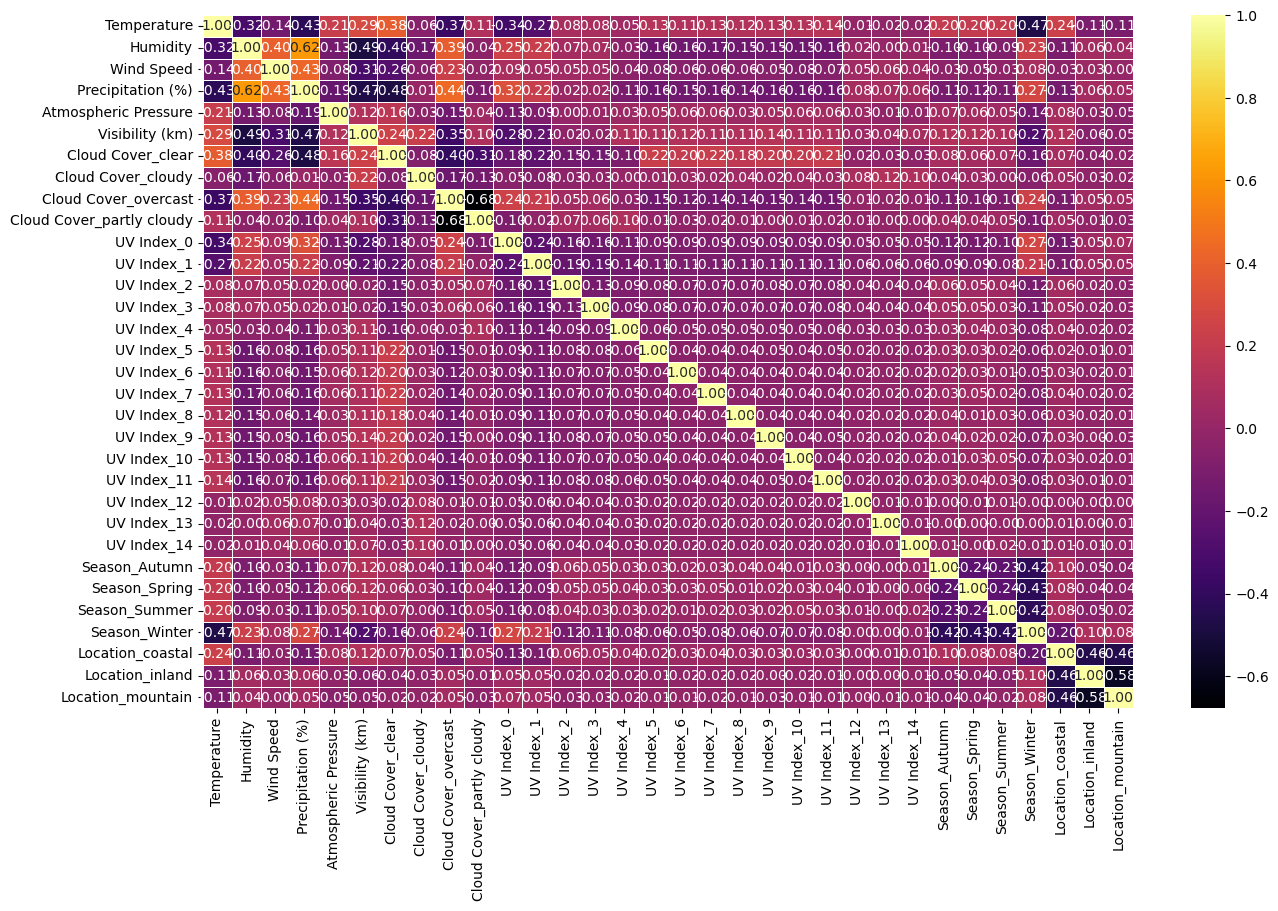

Top 10 highest (absolute) correlations:
Cloud Cover_partly cloudy  Cloud Cover_overcast    0.677854
Precipitation (%)          Humidity                0.621101
Location_mountain          Location_inland         0.576780
Visibility (km)            Humidity                0.493071
Cloud Cover_clear          Precipitation (%)       0.483722
Visibility (km)            Precipitation (%)       0.472077
Season_Winter              Temperature             0.470464
Location_mountain          Location_coastal        0.460758
Location_inland            Location_coastal        0.459263
Cloud Cover_overcast       Precipitation (%)       0.440185
dtype: float64


In [27]:
# generate a basic correlation matrix to visualize relationships

correlation_matrix = processed_df.drop(columns=["Weather Type"]).corr()
# Plot heatmap for better visualization
plt.figure(figsize=(15, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="inferno", fmt=".2f", linewidths=0.5)
plt.show()

# print 10 values with highest (absolute value) correlation
corr_abs = correlation_matrix.abs()
upper_triangle = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
top10 = upper_triangle.unstack().sort_values(ascending=False).head(10)

print("Top 10 highest (absolute) correlations:")
print(top10)

The correlations make logical sense, showing the dataset isn't completely random even though it's synthetic. This indicates we may be to train a useful model.

## Boxplots

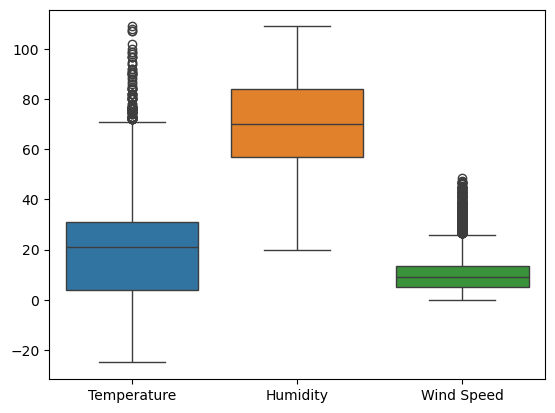

In [31]:
sns.boxplot(data=df[['Temperature', 'Humidity', 'Wind Speed']])
plt.show()

The box plots compares Temperature, Humidity, and Wind Speed. Temperatures has a large range
(~4 to 32) and many outliers above 70C. Humidity is symmetric with few to no outliers after
processing. Wind speed has a low median value, but a high number of outliers

#  Methods 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X = processed_df.drop(columns=["Weather Type"])
y = label_encoder.fit_transform(processed_df["Weather Type"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Test Accuracy: 0.8826


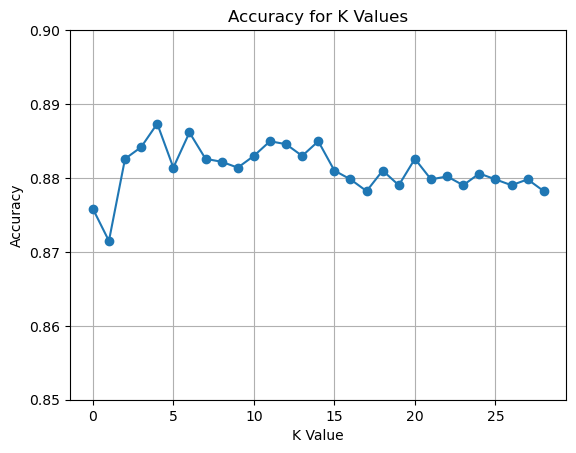

In [40]:
# generate a graph for k values

accuracy = []
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

plt.plot(accuracy, marker='o')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.title('Accuracy for K Values')
plt.ylim(0.85, .9)
plt.grid(True)
plt.show()

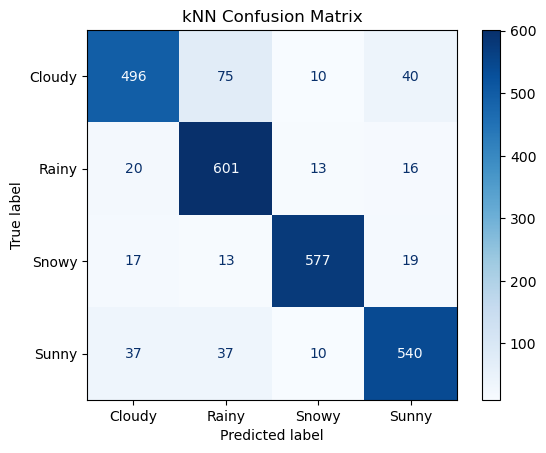

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

label_encoder_decoder = ["Cloudy", "Rainy", "Snowy", "Sunny"]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder_decoder, cmap='Blues')
plt.title('kNN Confusion Matrix')
plt.show()

### Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier(criterion='gini', max_depth=3)

dt.fit(X_train, y_train)

print(f"Accuracy Score: {dt.score(X_test, y_test)}")

Accuracy Score: 0.8357794525981753


Now we plot the decision tree we just made, confirming it has a max depth of 3, and seeing what features are being used to do the classification.

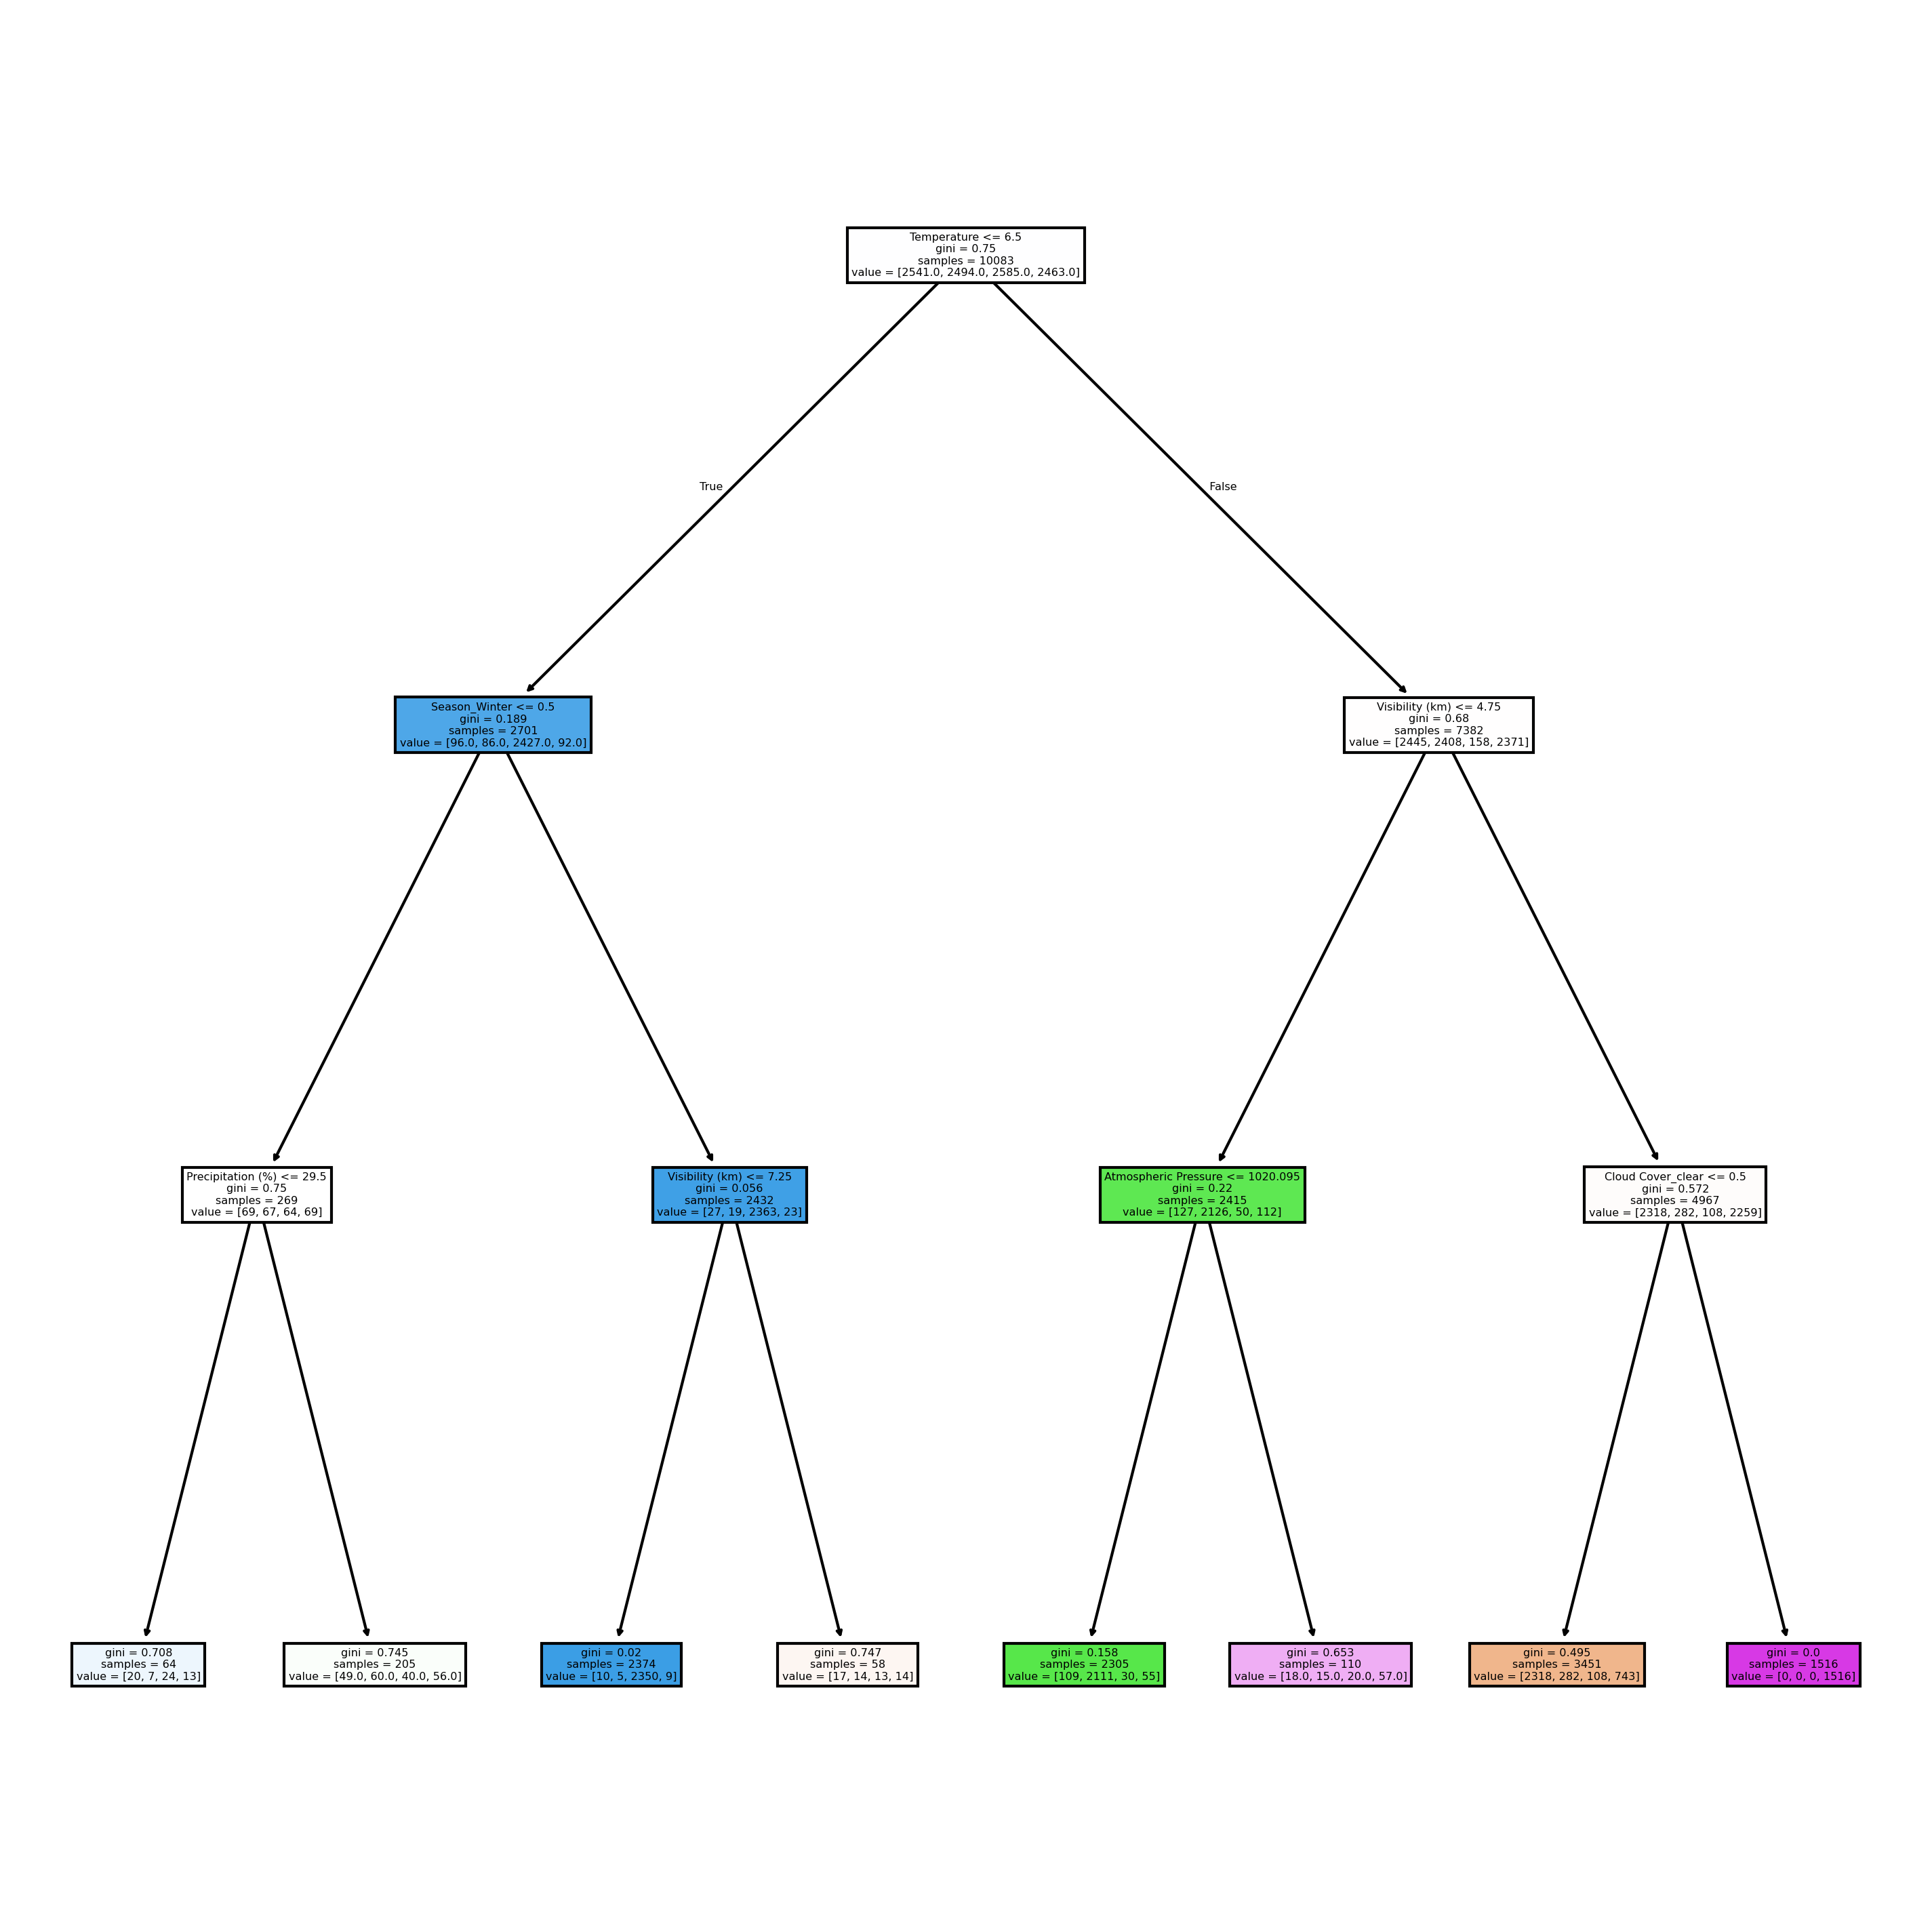

In [48]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (12,12), dpi=300)
plot_tree(dt, max_depth = 3, feature_names = X.columns, filled=True)
plt.show()

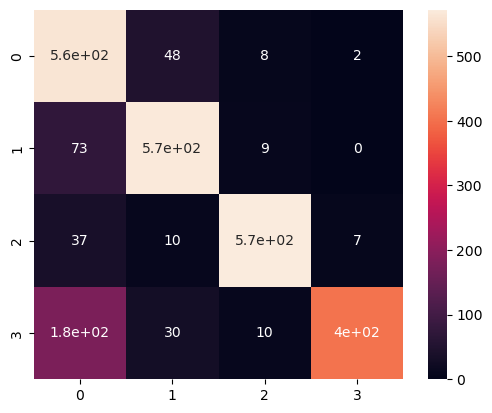

In [50]:
from sklearn.metrics import confusion_matrix

y_pred = dt.predict(X_test)

cf = confusion_matrix(y_test, y_pred)

sns.heatmap(cf, annot=True, square=True)
plt.show()

### Random Forest

In [57]:
# Imports
from sklearn.ensemble import RandomForestClassifier

# Training
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")

Random Forest Test Accuracy: 0.9139


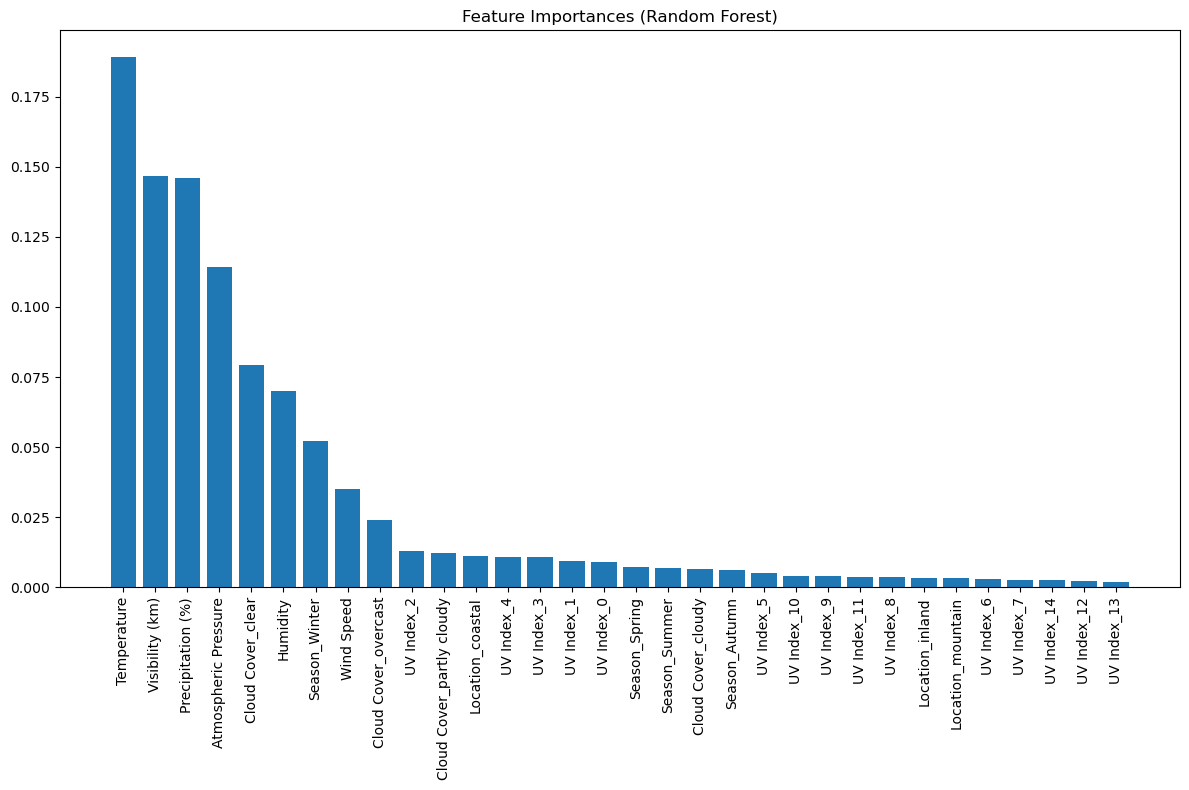

In [59]:
# Plotting
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

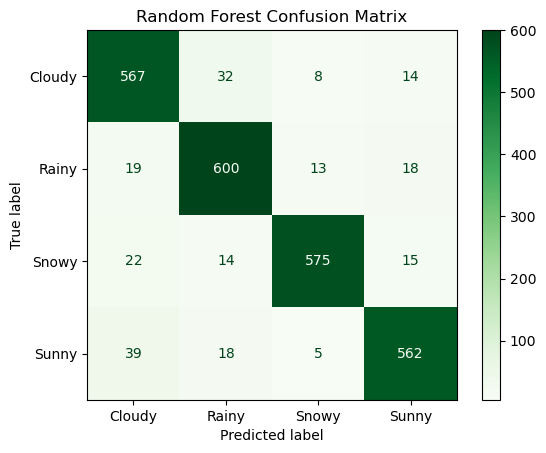

In [61]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=label_encoder_decoder, cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.show()

#  Evaluation 

# Impact

Many different impacts can come from our project, these impacts can be both positive and negative. One of those negative impacts is that the dataset we are using is a synthetic dataset, which means that the data mimics real-world data. This is viewed as a negative impact because the data can be seen as limited or not an accurate representation of real weather data, so the project results could be seen as unreliable. Not only this, but having unreliable models that can predict weather shrink public trust in meteorologists, so having accurate models is very important. A positive impact that can come from this project is the potential improvements to weather forecasting through better prediction outcomes, given that we supplement some synthetic data with real world data, which can benefit both space exploration and even the lives of the average person. Others include the potential to build more advanced models for more advanced weather patterns, and saving lives with accurate predictions.

### Github Repository/Code/Data
https://github.com/ajebril1/weather_prediction